<a href="https://colab.research.google.com/github/JoseManuel1007/Proyecto2/blob/main/analisis_baterias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelos de batería disponibles:
- B0047
- B0045
- B0048
- B0046
- B0043
- B0032
- B0039
- B0040
- B0029
- B0028
- B0042
- B0034
- B0038
- B0033
- B0030
- B0041
- B0027
- B0044
- B0036
- B0025
- B0026
- B0031
- B0049
- B0050
- B0052
- B0051
- B0006
- B0005
- B0007
- B0018
- B0053
- B0054
- B0056
- B0055

Ingrese el modelo de batería (ej. B0005): B0056

La batería B0056 tiene 252 ciclos registrados.
Ingrese el número de ciclo que desea analizar: 21


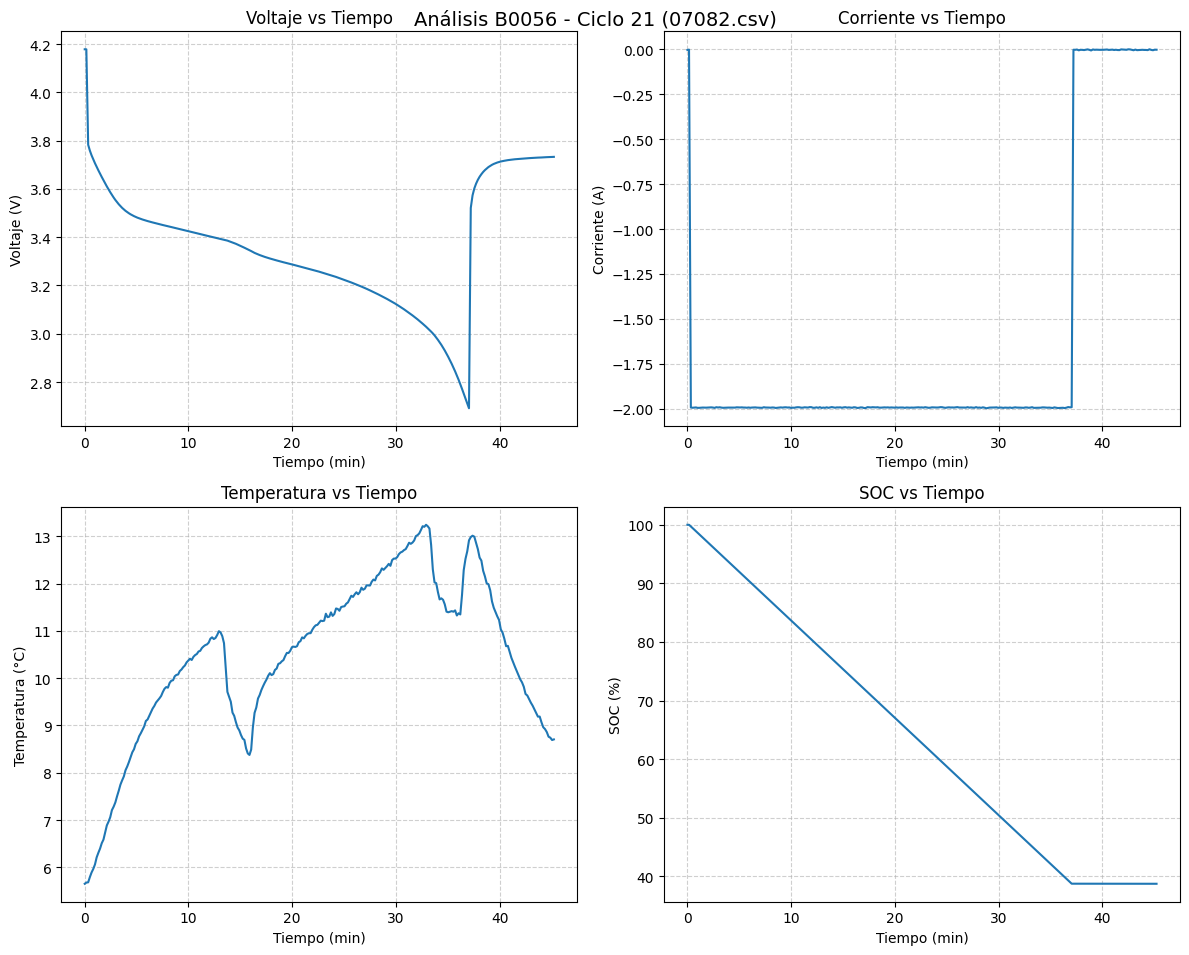

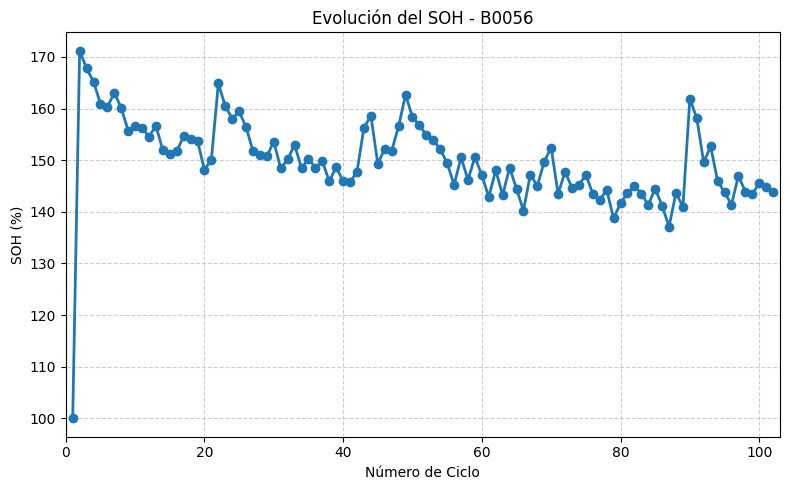

Análisis completado correctamente.

=== Calculadora de almacenamiento ===
ID de batería (ej. B0047): B0005
Energía deseada (kWh): 50
Tipo de conexión (serie/paralelo): serie

Cálculo para B0005
Tipo conexión: serie
Energía por celda: 7.40 Wh
Energía deseada: 50000 Wh (50.0 kWh)
Número de celdas requerido (estimado): 6757
Voltaje total (estimado): 25000.00 V
Capacidad total (estimada): 2.00 Ah

Dimensionamiento del sistema
1) Vehículo eléctrico
2) Vivienda (BESS)
Ingrese opción (1/2): 1
Energía requerida (kWh): 52
Modelos disponibles:
- B0005
- B0006
- B0007
- B0018
ID de la celda: B0006
Configuración (serie/paralelo): serie

Resultados:
Aplicación: vehículo eléctrico
Energía requerida: 52.00 kWh
Celda: B0006
Número de celdas (estimado): 7222
Peso total estimado: 332.22 kg
Energía total estimada: 52.00 kWh

¿Desea comparar con otra química? (s/n): s

Seleccione la segunda celda para comparar:
- B0005
- B0006
- B0007
- B0018
ID de la segunda celda: B0005

--- Comparación entre químicas -

In [12]:
# Entrega final - Proyecto 2: Análisis de datos de baterías (Colab + Drive)
# Ejecutar en Google Colab. El script monta Drive, carga metadata, permite
# seleccionar una batería y un ciclo, calcula SOC/SOH y presenta gráficos.

import os
import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

# ---------------------------
# 1) Rutas y comprobaciones
# ---------------------------
BASE_PATH = "/content/proyecto2"
os.makedirs(BASE_PATH, exist_ok=True)

GOOGLE_DRIVE_DATA_PATH = "/content/drive/MyDrive/Proyecto2"
metadata_path = os.path.join(GOOGLE_DRIVE_DATA_PATH, "metadata.csv")
data_folder = os.path.join(GOOGLE_DRIVE_DATA_PATH, "data")

if not os.path.exists(metadata_path):
    raise FileNotFoundError(f"No se encontró metadata.csv en: {metadata_path}")
if not os.path.exists(data_folder) or len(os.listdir(data_folder)) == 0:
    raise FileNotFoundError(f"No se encontraron archivos en la carpeta de Drive: {data_folder}")

# ---------------------------
# 2) Lectura de metadata
# ---------------------------
# Definimos los nombres esperados para las columnas del CSV de metadata.
column_names = [
    'type', 'start_time', 'ambient_temperature', 'battery_id',
    'test_id', 'uid', 'filename', 'Capacity', 'Re', 'Rct'
]

def read_metadata(path):
    """
    Intenta leer metadata.csv con delimitador ',' y si falla, intenta ';'.
    También elimina una fila de encabezado leída como dato si existe.
    """
    for sep in [',', ';']:
        try:
            m = pd.read_csv(path, delimiter=sep, header=None, names=column_names)
            if len(m) > 0 and str(m.iloc[0]['type']).strip().lower() == 'type':
                m = m.iloc[1:].reset_index(drop=True)
            return m
        except Exception:
            continue
    raise ValueError("No se pudo leer metadata.csv con los delimitadores esperados")

metadata = read_metadata(metadata_path)

# ---------------------------
# 4) Selección de batería y ciclo
# ---------------------------
# Mostrar modelos disponibles para que el usuario elija
modelos = metadata['battery_id'].unique()
print("Modelos de batería disponibles:")
for modelo in modelos:
    print("-", modelo)

# Solicitar modelo al usuario
bateria = input("\nIngrese el modelo de batería (ej. B0005): ").strip()
bateria_data = metadata[metadata['battery_id'] == bateria].reset_index(drop=True)
if bateria_data.empty:
    raise ValueError(f"No se encontró información para la batería {bateria}")

# Solicitar ciclo a analizar
print(f"\nLa batería {bateria} tiene {len(bateria_data)} ciclos registrados.")
indice = int(input("Ingrese el número de ciclo que desea analizar: "))
if indice < 1 or indice > len(bateria_data):
    raise ValueError("Número de ciclo fuera de rango.")

# Obtener nombre de archivo y construir ruta
filename = bateria_data.loc[indice - 1, 'filename']
file_path = os.path.join(data_folder, filename)

# Si el nombre exacto no existe, buscar coincidencias aproximadas (por prefijo)
if not os.path.exists(file_path):
    pref = os.path.splitext(filename)[0].lower()
    posibles = [f for f in os.listdir(data_folder) if f.lower().startswith(pref)]
    if len(posibles) == 1:
        file_path = os.path.join(data_folder, posibles[0])
    else:
        raise FileNotFoundError(f"No se encontró {filename}. Archivos similares: {posibles}")

# ---------------------------
# 5) Carga del archivo de ciclo
# ---------------------------
# Leemos el CSV del ciclo seleccionado.
df = pd.read_csv(file_path)

# ---------------------------
# 6) Cálculo de SOC y SOH
# ---------------------------
def calcular_soc(df, capacidad_nominal=2.0):
    """
    Calcula SOC (%) integrando la corriente medida sobre el tiempo.
    - 'Time' debe estar en segundos.
    - 'Current_measured' debe estar en amperios.
    """
    if 'Time' not in df.columns or 'Current_measured' not in df.columns:
        raise KeyError("Faltan columnas 'Time' o 'Current_measured' en el CSV de ciclo.")
    x = df.copy()
    x['Time_hr'] = x['Time'] / 3600.0
    # Usamos np.gradient para obtener dt y multiplicamos por valor absoluto de corriente
    dt = np.gradient(x['Time_hr'].to_numpy())
    ah = np.cumsum(np.abs(x['Current_measured'].to_numpy()) * dt)
    x['Ah_descargados'] = ah
    x['SOC (%)'] = 100 * (1 - ah / capacidad_nominal)
    x['SOC (%)'] = x['SOC (%)'].clip(0, 100)
    return x

def calcular_soh(metadata_bateria):
    """
    Calcula SOH (%) por ciclo usando la columna 'Capacity' de metadata.
    Considera sólo filas con type == 'discharge' (no sensible a mayúsculas).
    """
    d = metadata_bateria[metadata_bateria['type'].astype(str).str.lower() == 'discharge'].copy()
    d['Capacity'] = pd.to_numeric(d['Capacity'], errors='coerce')
    d = d.dropna(subset=['Capacity']).reset_index(drop=True)
    if d.empty:
        print("Advertencia: No hay datos de descarga válidos en metadata para calcular SOH.")
        return pd.DataFrame(columns=['Capacity', 'SOH (%)', 'Cycle']) # Devolver un DataFrame vacío si no hay datos de descarga válidos
    cap0 = d['Capacity'].iloc[0]
    d['SOH (%)'] = (d['Capacity'] / cap0) * 100
    # Asegurarse de que el ciclo empiece en 1 y vaya hasta el número total de ciclos de descarga
    d['Cycle'] = range(1, len(d) + 1)
    return d

# Ejecutar cálculos
df = calcular_soc(df)
soh_data = calcular_soh(bateria_data)

# ---------------------------
# 7) Gráficos (Voltaje, Corriente, Temperatura, SOC)
# ---------------------------
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(df['Time'] / 60, df['Voltage_measured'])
plt.title('Voltaje vs Tiempo')
plt.xlabel('Tiempo (min)')
plt.ylabel('Voltaje (V)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(2, 2, 2)
plt.plot(df['Time'] / 60, df['Current_measured'])
plt.title('Corriente vs Tiempo')
plt.xlabel('Tiempo (min)')
plt.ylabel('Corriente (A)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(2, 2, 3)
if 'Temperature_measured' in df.columns:
    plt.plot(df['Time'] / 60, df['Temperature_measured'])
    plt.title('Temperatura vs Tiempo')
    plt.xlabel('Tiempo (min)')
    plt.ylabel('Temperatura (°C)')
    plt.grid(True, linestyle='--', alpha=0.6)
else:
    plt.text(0.5, 0.5, 'No hay columna Temperature_measured', ha='center', va='center')
    plt.axis('off')

plt.subplot(2, 2, 4)
plt.plot(df['Time'] / 60, df['SOC (%)'])
plt.title('SOC vs Tiempo')
plt.xlabel('Tiempo (min)')
plt.ylabel('SOC (%)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle(f'Análisis {bateria} - Ciclo {indice} ({os.path.basename(file_path)})', fontsize=14, y=0.95)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
# Verificar si soh_data no está vacío antes de graficar
if not soh_data.empty:
    plt.plot(soh_data['Cycle'], soh_data['SOH (%)'], marker='o', linewidth=2)
    plt.title(f'Evolución del SOH - {bateria}')
    plt.xlabel('Número de Ciclo')
    plt.ylabel('SOH (%)')
    plt.xlim(0, soh_data['Cycle'].max() + 1) # Asegurarse de que el eje X tenga un rango adecuado basado en los ciclos
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No se pudo generar la gráfica de Evolución del SOH debido a la falta de datos de descarga válidos.")


print("Análisis completado correctamente.")

# ---------------------------
# 8) Calculadora de energía (interactiva)
# ---------------------------
baterias = {
    "B0005": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0006": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0007": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0018": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0029": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0030": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0047": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
    "B0048": {"V_nominal": 3.7, "Capacidad_Ah": 2.0},
}

def calcular_celdas(bateria, energia_kwh, tipo_conexion):
    """
    Calcula número estimado de celdas, voltaje y capacidad del banco.
    - energia_kwh: energía deseada en kWh (float)
    - tipo_conexion: 'serie' o 'paralelo'
    """
    if bateria not in baterias:
        print("Batería no encontrada.")
        return
    datos = baterias[bateria]
    energia_celda_Wh = datos["V_nominal"] * datos["Capacidad_Ah"]
    energia_deseada_Wh = energia_kwh * 1000
    n_celdas = energia_deseada_Wh / energia_celda_Wh
    if tipo_conexion == "serie":
        voltaje_total = n_celdas * datos["V_nominal"]
        capacidad_total = datos["Capacidad_Ah"]
    elif tipo_conexion == "paralelo":
        voltaje_total = datos["V_nominal"]
        capacidad_total = n_celdas * datos["Capacidad_Ah"]
    else:
        print("Tipo de conexión inválido. Use 'serie' o 'paralelo'.")
        return
    print(f"\nCálculo para {bateria}")
    print(f"Tipo conexión: {tipo_conexion}")
    print(f"Energía por celda: {energia_celda_Wh:.2f} Wh")
    print(f"Energía deseada: {energia_deseada_Wh:.0f} Wh ({energia_kwh} kWh)")
    print(f"Número de celdas requerido (estimado): {n_celdas:.0f}")
    print(f"Voltaje total (estimado): {voltaje_total:.2f} V")
    print(f"Capacidad total (estimada): {capacidad_total:.2f} Ah")

print("\n=== Calculadora de almacenamiento ===")
bateria_calc = input("ID de batería (ej. B0047): ").strip()
energia_kwh = float(input("Energía deseada (kWh): "))
tipo_conexion = input("Tipo de conexión (serie/paralelo): ").strip().lower()
calcular_celdas(bateria_calc, energia_kwh, tipo_conexion)

# ---------------------------
# 9) Dimensionamiento del sistema (opcional)
# ---------------------------
def dimensionamiento_sistema():
    """
    Interfaz simple para dimensionar un sistema según aplicación y celda seleccionada.
    Calcula número de celdas, masa estimada y energía total.
    """
    print("\nDimensionamiento del sistema")
    print("1) Vehículo eléctrico")
    print("2) Vivienda (BESS)")
    opcion = input("Ingrese opción (1/2): ").strip()
    aplicacion = "vehículo eléctrico" if opcion == "1" else "vivienda" if opcion == "2" else None
    if aplicacion is None:
        print("Opción inválida.")
        return
    energia_kwh = float(input("Energía requerida (kWh): "))
    baterias_dim = {
        "B0005": {"V_nominal": 3.7, "Capacidad_Ah": 2.0, "Masa_kg": 0.045, "Densidad_Wh_kg": 164},
        "B0006": {"V_nominal": 3.6, "Capacidad_Ah": 2.0, "Masa_kg": 0.046, "Densidad_Wh_kg": 156},
        "B0007": {"V_nominal": 3.7, "Capacidad_Ah": 2.2, "Masa_kg": 0.047, "Densidad_Wh_kg": 173},
        "B0018": {"V_nominal": 3.7, "Capacidad_Ah": 1.9, "Masa_kg": 0.044, "Densidad_Wh_kg": 160}
    }
    print("Modelos disponibles:")
    for k in baterias_dim.keys():
        print("-", k)
    celda_id = input("ID de la celda: ").strip().upper()
    if celda_id not in baterias_dim:
        print("Celda no encontrada.")
        return
    celda = baterias_dim[celda_id]
    energia_celda_Wh = celda["V_nominal"] * celda["Capacidad_Ah"]
    n_celdas = (energia_kwh * 1000) / energia_celda_Wh
    peso_total = n_celdas * celda["Masa_kg"]
    tipo_config = input("Configuración (serie/paralelo): ").strip().lower()
    if tipo_config == "serie":
        voltaje_total = n_celdas * celda["V_nominal"]
        capacidad_total = celda["Capacidad_Ah"]
    elif tipo_config == "paralelo":
        voltaje_total = celda["V_nominal"]
        capacidad_total = n_celdas * celda["Capacidad_Ah"]
    else:
        voltaje_total = n_celdas * celda["V_nominal"]
        capacidad_total = celda["Capacidad_Ah"]

    energia_total_Wh = voltaje_total * capacidad_total
    print("\nResultados:")
    print(f"Aplicación: {aplicacion}")
    print(f"Energía requerida: {energia_kwh:.2f} kWh")
    print(f"Celda: {celda_id}")
    print(f"Número de celdas (estimado): {n_celdas:.0f}")
    print(f"Peso total estimado: {peso_total:.2f} kg")
    print(f"Energía total estimada: {energia_total_Wh/1000:.2f} kWh")

    # Comparación de químicas dentro de la función de dimensionamiento
    comparar = input("\n¿Desea comparar con otra química? (s/n): ").strip().lower()
    if comparar == "s":
        print("\nSeleccione la segunda celda para comparar:")
        for k in baterias_dim.keys():
            print(f"- {k}")
        celda_comp_id = input("ID de la segunda celda: ").strip().upper()
        if celda_comp_id not in baterias_dim:
            print("Celda no encontrada.")
            return

        celda_comp = baterias_dim[celda_comp_id]
        energia_celda_comp_Wh = celda_comp["V_nominal"] * celda_comp["Capacidad_Ah"]
        n_celdas_comp = (energia_kwh * 1000) / energia_celda_comp_Wh
        peso_total_comp = n_celdas_comp * celda_comp["Masa_kg"]

        print("\n--- Comparación entre químicas ---")
        print(f"{celda_id}: {peso_total:.2f} kg para {energia_kwh:.2f} kWh")
        print(f"{celda_comp_id}: {peso_total_comp:.2f} kg para {energia_kwh:.2f} kWh")

        if peso_total > 0:
            diff_pct = ((peso_total_comp - peso_total) / peso_total) * 100
            print(f"Diferencia de peso: {diff_pct:+.2f}% (positivo => {celda_comp_id} es más pesado que {celda_id})")
        else:
            print("No se pudo calcular diferencia porcentual de peso (masa no disponible para la primera celda).")


# Ejecutar la función principal de dimensionamiento si el script es ejecutado directamente
if __name__ == "__main__":
    dimensionamiento_sistema()